# Homework 2
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object. In particular:

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on the results of each image, and print the estimated flux.

2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

3. Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by `Atrue/Amean` (where `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

## Solution

### Q1.
Generate a few (say, three) simulated image of a star using the simulatedImage function for different seed values, and visualize them using plotCutout. Run psfPhot and apPhot on the results of each image, and print the estimated flux.

In [48]:
%matplotlib inline

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=False)

import numpy as np
import math
import matplotlib.pyplot as plt

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(200, 400)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [49]:
Atrue = 1000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 250.0     # sky background

In [50]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

### Task 1

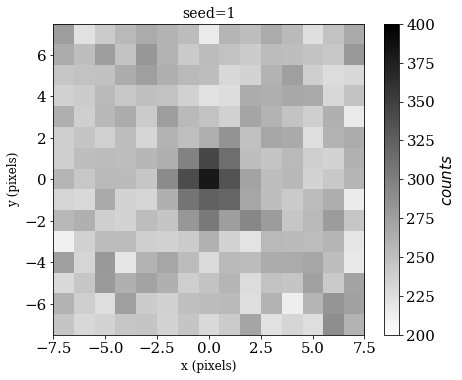

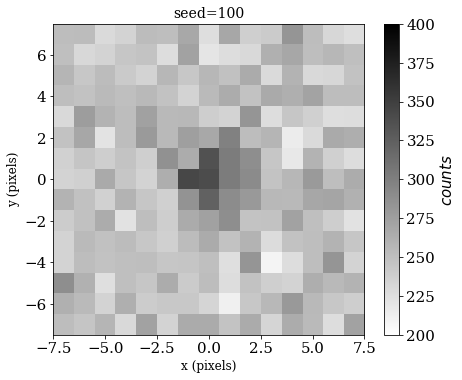

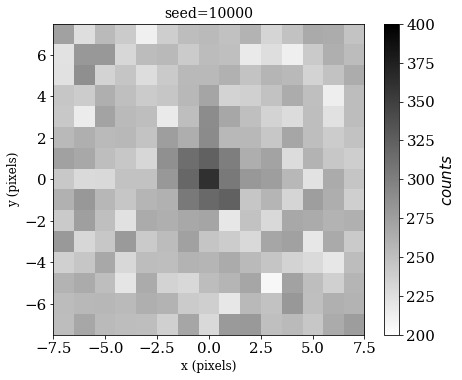

In [51]:
### Make your three simulated images here

seed = [1,100,10000]
first_image = simulatedImage(seed = seed[0])
second_image = simulatedImage(seed = seed[1])
third_image = simulatedImage(seed = seed[2])

### Visualize three simulated images using plotCutout.
plotCutout(first_image, title = 'seed=%i'%seed[0], clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None)
plotCutout(second_image, title = 'seed=%i'%seed[1], clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None)
plotCutout(third_image, title = 'seed=%i'%seed[2], clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None)




### Task 2

In [52]:
def apPhot(image, r = 3, x0=0, y0=0):
    # Compute the aperture magnitude
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum()

def psfPhot(image, Amin = 600, Amax = 1400):
    
    sigmaNoise = np.sqrt(image)     # Estimate the noise in the image

    
    image = image - skyBg           # Subtract the background (we assume we've estimated it somehow)
    
    sigmaNoise = np.sqrt(skyBg)

    # search for best flux by gridding
    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best[0]

In [53]:
### Run psfPhot and apPhot on the results of each image, and print the estimated flux.   flux???

apPhot1 = apPhot(first_image)
apPhot2 = apPhot(second_image)
apPhot3 = apPhot(third_image)

psfPhot1 = psfPhot(first_image)
psfPhot2 = psfPhot(second_image)
psfPhot3 = psfPhot(third_image)


print('First image: seed=%i, apPhot=%f, psfPhot=%f.'%(seed[0], apPhot1, psfPhot1))
print('Second image: seed=%i, apPhot=%f, psfPhot=%f.'%(seed[1], apPhot2, psfPhot2))
print('Third image: seed=%i, apPhot=%f, psfPhot=%f.'%(seed[2], apPhot3, psfPhot3))

First image: seed=1, apPhot=1036.000000, psfPhot=1125.000000.
Second image: seed=100, apPhot=837.000000, psfPhot=897.000000.
Third image: seed=10000, apPhot=910.000000, psfPhot=955.000000.


### Q2.
Write a function centerPhot that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?


In [54]:
def centerPhot(image):
    #### DEFINE YOUR FUNCTION HERE ####
    image = image - skyBg 
    return  image[7][7]                   #image[np.where(xx==0)][np.where(yy==0)]
    
centerPhot1 = centerPhot(first_image)
centerPhot2 = centerPhot(second_image)
centerPhot3 = centerPhot(third_image)

print('Fist image: seed=%i, centerPhot=%.2f.'%(seed[0], centerPhot1))
print('Second image: seed=%i, centerPhot=%.2f.'%(seed[1], centerPhot2))
print('Third image: seed=%i, centerPhot=%.2f'%(seed[2], centerPhot3))

Fist image: seed=1, centerPhot=130.00.
Second image: seed=100, centerPhot=90.00.
Third image: seed=10000, centerPhot=111.00


The value of the central pixel estimator is biased a lot because we don't include photons spread out from the center. 

### Task 3 / 4

### Q3.
Generate a thousand different simulated images using simulatedImage, and compute centerPhot, psfPhot, and apPhot for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using np.average) and standard deviation (with np.std)

/home/fuchi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


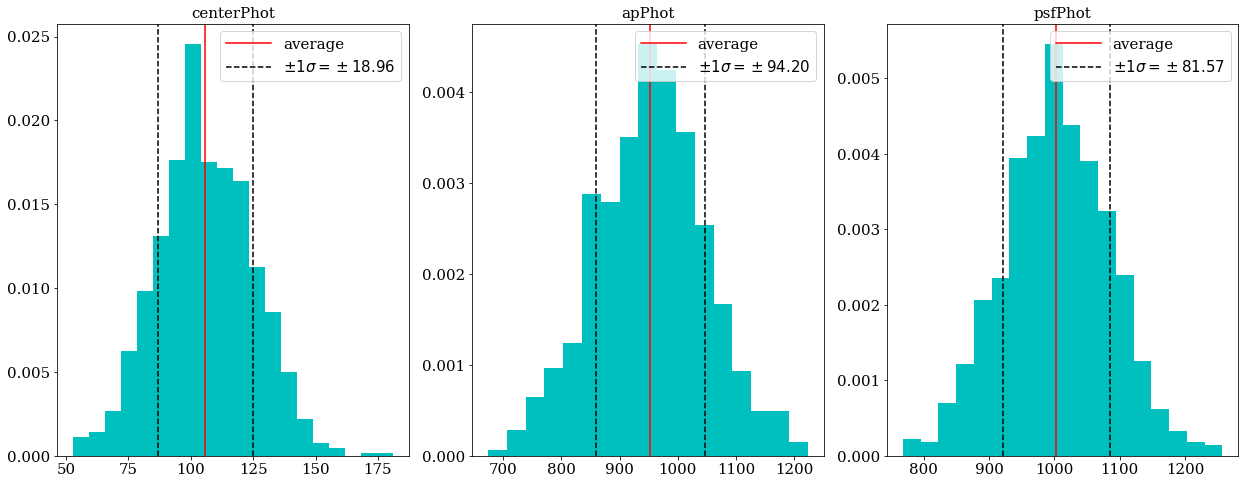

In [55]:
### Generate a thousand different simulated images and compute centerPhot, psfPhot, and apPhot.
s=1
a=np.zeros(shape=1000)
b=np.zeros(shape=1000)
c=np.zeros(shape=1000)
for i in range(1000):
    image = simulatedImage(s)
    a[i] = centerPhot(image) 
    b[i] =  apPhot(image) 
    c[i] = psfPhot(image) 
    
    s+=10

### Plot hist
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
fig.subplots_adjust(left=0.13, bottom=0.15, right=0.95, top=0.90, wspace=0.18)



ax1.hist(a, bins="scott", range=None, color='c', normed=True)
ax2.hist(b, bins="scott", range=None, color='c', normed=True)
ax3.hist(c, bins="scott", range=None, color='c', normed=True)



ax1.axvline(np.average(a),color='r',label='average')
ax1.axvline(np.average(a)+np.std(a), color='k', linestyle='--')
ax1.axvline(np.average(a)-np.std(a), color='k', linestyle='--',  label="$\pm1\sigma=\pm%.2f$"%np.std(a))
ax1.set_title('centerPhot')

ax2.axvline(np.average(b),color='r',label='average')
ax2.axvline(np.average(b)+np.std(b), color='k', linestyle='--')
ax2.axvline(np.average(b)-np.std(b), color='k', linestyle='--',  label="$\pm1\sigma=\pm%.2f$"%np.std(b))
ax2.set_title("apPhot")

ax3.axvline(np.average(c),color='r',label='average')
ax3.axvline(np.average(c)+np.std(c), color='k', linestyle='--')
ax3.axvline(np.average(c)-np.std(c), color='k', linestyle='--',  label="$\pm1\sigma=\pm%.2f$"%np.std(c))
ax3.set_title("psfPhot")

ax1.legend()
ax2.legend()
ax3.legend()

In [56]:
print(np.average(a), np.average(b), np.average(c))

105.866 953.05 1002.84


### Q4.
Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by Atrue/Amean (where Amean is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

/home/fuchi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


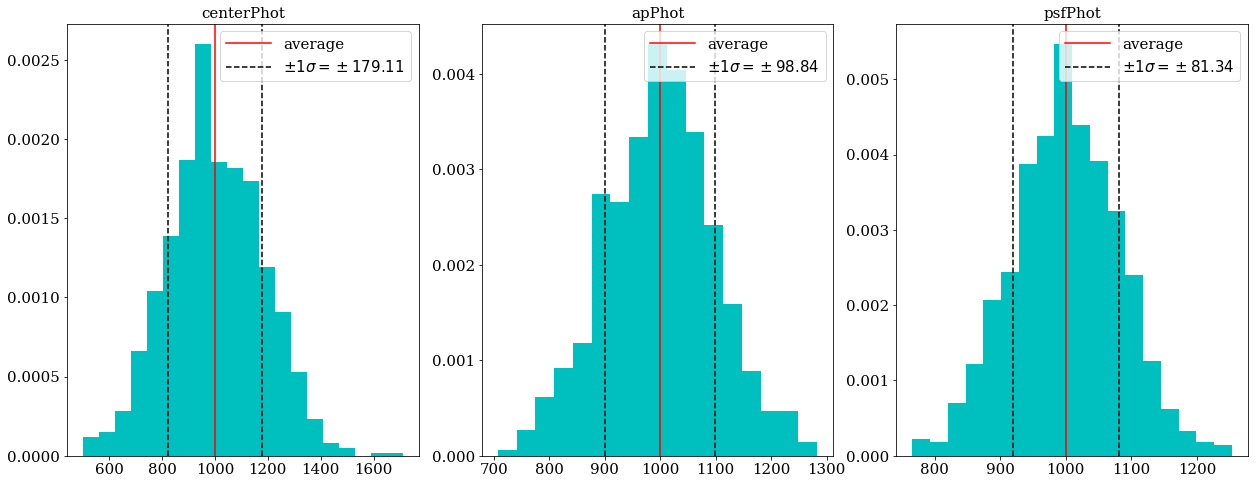

In [57]:
### Multiply each of them by Atrue/Amean 

a2 = a*Atrue/np.average(a)
b2 = b*Atrue/np.average(b)
c2 = c*Atrue/np.average(c)


### Plot
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
fig.subplots_adjust(left=0.13, bottom=0.15, right=0.95, top=0.90, wspace=0.18)


hist1 = ax1.hist(a2, bins="scott", range=None, color='c', normed=True)
hist2 = ax2.hist(b2, bins="scott", range=None, color='c', normed=True)
hist3 = ax3.hist(c2, bins="scott", range=None, color='c', normed=True)


ax1.axvline(np.average(a2),color='r',label='average')
ax1.axvline(np.average(a2)+np.std(a2), color='k', linestyle='--')
ax1.axvline(np.average(a2)-np.std(a2), color='k', linestyle='--', label="$\pm1\sigma=\pm%.2f$"%np.std(a2))
ax1.set_title('centerPhot')


ax2.axvline(np.average(b2),color='r',label='average')
ax2.axvline(np.average(b2)+np.std(b2), color='k', linestyle='--')
ax2.axvline(np.average(b2)-np.std(b2), color='k', linestyle='--', label="$\pm1\sigma=\pm%.2f$"%np.std(b2))
ax2.set_title("apPhot")

ax3.axvline(np.average(c2),color='r',label='average')
ax3.axvline(np.average(c2)+np.std(c2), color='k', linestyle='--')
ax3.axvline(np.average(c2)-np.std(c2), color='k', linestyle='--', label="$\pm1\sigma=\pm%.2f$"%np.std(c2))
ax3.set_title("psfPhot")


ax1.legend(loc=1)
ax2.legend(loc=1)
ax3.legend(loc=1)

The psfPhot one is the narrowest, which can be seen from the standard deviation.
The standard deviation of the histogram from using centerPhot is the largest. The smallest one is the histogram from using point spread function. The psfPhot has the smallest standard deviation because the source (a star) is described by point spread function and theredfore it has the largest source to noise. Less noise means less deviation and so smaller standard deviation. 